# Libraries

In [169]:
# Basic libraries
import numpy as np
import math
import matplotlib 
import pandas as pd

# Graphic libraries
import matplotlib.pyplot as plt

# 3 decimal places
np.set_printoptions(precision=3)


# Constants and initial data:

In [170]:
# Number of layers (lamina)
#n = int(input('Layers:'))
n = 17

# Orientation of each lamina
#direc = [[0 for _ in range(1)] for _ in range(n)]
direc = np.radians([90,0,0,0,90,90,90,0,1,91,2,3,5,19,38,37,35])

# Mechanical load
# Nx = float(input('Normal force Nx (N/mm):'))
# Ny = float(input('Normal force Ny (N/mm):'))
# Nxy = float(input('Shear force Nxy (N/mm):'))
# Mx = float(input('Momentum Mx (Nmm/mm):'))
# My = float(input('Momentum My (Nmm/mm):'))
# Mxy = float(input('Momentum Mxy (Nmm/mm):'))

# carreg = [[Nx*1000],[Ny*1000],[Nxy*1000],[Mx],[My],[Mxy]] # N/m

carreg = [[2109*1000],[-1231*1000],[-2.72*1000],[-2274],[1166],[-75]] # N/m

# Thickness of each lamina
#esp = float(input('Thickness (mm):'))*10**-3
esp = 0.408E-3

# Structure thickness
h = n*esp #m

# Material propertires
# E11 = float(input('Elastic modulus in direction 1 (GPa):'))*10**9
# E22 = float(input('Elastic modulus in direction 2 (GPa):'))*10**9
# nu12 = float(input('Poisson ratio:'))
# G12 = float(input('Shear modulus (GPa):'))*10**9

E11 = 138E9
E22 = 8.96E9
G12 = 7.1E9
nu12 = 0.3

# Relation between Poisson ratios
nu21 = (E22*nu12)/E11

# Material resistances:
# XT = float(input('Resistance limit to traction in direction 1 (MPa):'))*10**-6
# XC = float(input('Resistance limit to compression in direction 1 (MPa)::'))*-10**-6
# YT = float(input('Resistance limit to traction in direction 2 (MPa):'))*10**-6
# YC = float(input('Resistance limit to compression in direction 2 (MPa):'))*-10**-6
# S12 = float(input('Resistance limit to shear (MPa):'))*10**-6

XT = 1447E6
XC = -1447E6
YT = 51.7E6
YC = -206E6
S12 = 93E6


# Reduced stiffness matrix in the global coordinate system

In [171]:
Q11 = E11/(1-nu12*nu21)
Q22 = E22/(1-nu12*nu21)
Q66 = G12
Q12 = (nu12*E22)/(1-nu12*nu21)
Q21 = Q12

Q = np.array([[Q11, Q12, 0],[Q21, Q22, 0], [0, 0, Q66]])

cos = np.cos(direc)
sin = np.sin(direc)

# Empty vectors
T = [[0 for _ in range(1)] for _ in range(n)]
T_inv = [[0 for _ in range(1)] for _ in range(n)]
Q_dash = [[0 for _ in range(1)] for _ in range(n)]
Reuter = [[1,0,0],[0,1,0],[0,0,2]] # Reuter matrix

# Q_dash matrix for each lamina
for i in range(n):
    T[i] = np.array([[cos[i]**2, sin[i]**2, 2*sin[i]*cos[i]],[sin[i]**2, cos[i]**2, -2*sin[i]*cos[i]],[-sin[i]*cos[i], sin[i]*cos[i], cos[i]**2-sin[i]**2]])
    T_inv[i] = np.linalg.inv(T[i])
    Q_dash[i] = T_inv[i]@Q@Reuter@T[i]@np.linalg.inv(Reuter)



# "ABBD" matrix:

In [172]:
# Empty vectors
A_local = [[0 for _ in range(1)] for _ in range(n)]
B_local = [[0 for _ in range(1)] for _ in range(n)]
D_local = [[0 for _ in range(1)] for _ in range(n)]
A_global = 0
B_global = 0
D_global = 0

for i in range(n):
    A_local[i] = Q_dash[i]*(((((n/2)-(i+1))/n)*-h) - (((n/2 - i)/n)*-h))
    A_global = A_global + A_local[i]
    B_local[i] = 0.5*Q_dash[i]*(((((n/2)-(i+1))/n)*-h)**2 - (((n/2 - i)/n)*-h)**2)
    B_global = B_global + B_local[i]
    D_local[i] = (1/3)*Q_dash[i]*(((((n/2)-(i+1))/n)*-h)**3 - (((n/2 - i)/n)*-h)**3)
    D_global = D_global + D_local[i]

# Stacking A, B and D matrices 
linha1 = np.vstack((A_global,B_global))
linha2 = np.vstack((B_global,D_global))
ABBD = np.hstack((linha1,linha2))
print("ABBD matrix:")
print(ABBD)

ABBD matrix:
[[ 5.982e+08  5.569e+07  7.078e+07  7.181e+04  1.008e+05  1.758e+05]
 [ 5.569e+07  3.533e+08  3.076e+07  1.008e+05 -2.734e+05  8.630e+04]
 [ 7.078e+07  3.076e+07  8.618e+07  1.758e+05  8.630e+04  1.008e+05]
 [ 7.181e+04  1.008e+05  1.758e+05  2.257e+03  3.579e+02  4.695e+02]
 [ 1.008e+05 -2.734e+05  8.630e+04  3.579e+02  1.288e+03  2.439e+02]
 [ 1.758e+05  8.630e+04  1.008e+05  4.695e+02  2.439e+02  4.801e+02]]


# Deformation-curvature matrix

In [173]:
# Empty vector
def_curv = [[0],[0],[0],[0],[0],[0]]

def_curv = np.linalg.inv(ABBD)@carreg

epsilon_0_global = np.vstack((def_curv[0],def_curv[1],def_curv[2]))
K_global = np.vstack((def_curv[3],def_curv[4],def_curv[5])) # 1/m

#print("Deformation-curvature matrix:")
print(def_curv)


[[ 3.991e-03]
 [-3.780e-03]
 [-2.648e-05]
 [-9.706e-01]
 [ 6.525e-02]
 [-1.659e-02]]


# Stress and strain in each lamina (reference in the middle plane)

In [174]:
sigma_global = [[0 for _ in range(1)] for _ in range(n)]
sigma_local = [[0 for _ in range(1)] for _ in range(n)]
z = [[0 for _ in range(1)] for _ in range(n)]
epsilon_global = [[0 for _ in range(1)] for _ in range(n)]
epsilon_local = [[0 for _ in range(1)] for _ in range(n)]
y = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    z[i] = 0.5*(((((n/2)-(i+1))/n)*-h) + (((n/2 - i)/n)*-h))
    sigma_global[i] = (Q_dash[i]@(epsilon_0_global - (z[i]*K_global)))
    sigma_local[i] = T[i]@sigma_global[i]
    epsilon_global[i] = epsilon_0_global - z[i]*K_global
    epsilon_local[i] = T[i]@epsilon_global[i]

sigma_local_data = sigma_local[0]
epsilon_local_data = epsilon_local[0]
sigma_global_data = sigma_global[0]
epsilon_global_data = epsilon_global[0]

for i in range(n):
    if i < (n-1):
        sigma_local_data = np.hstack((sigma_local_data,sigma_local[i+1]))
        epsilon_local_data = np.hstack((epsilon_local_data,epsilon_local[i+1]))
        sigma_global_data = np.hstack((sigma_global_data,sigma_global[i+1]))
        epsilon_global_data = np.hstack((epsilon_global_data,epsilon_global[i+1]))

sigma_global_data = sigma_global_data*10**-6
sigma_local_data = sigma_local_data*10**-6

results_df = pd.DataFrame(
    {
        "sigma_x local (MPa)": sigma_local_data[0,:],
        "sigma_y local (MPa)": sigma_local_data[1,:],
        "sigma_xy local (MPa)": sigma_local_data[2,:],
        "epsilon_x local": epsilon_local_data[0,:],
        "epsilon_y local": epsilon_local_data[1,:],
        "gamma_xy local": epsilon_local_data[2,:],
        "sigma_x global (MPa)": sigma_global_data[0,:],
        "sigma_y global (MPa)": sigma_global_data[1,:],
        "sigma_xy global (MPa)": sigma_global_data[2,:],
        "epsilon_x global": epsilon_global_data[0,:],
        "epsilon_y global": epsilon_global_data[1,:],
        "gamma_xy global": epsilon_global_data[2,:]
    }
).T

print("Results for each lamina: ")
print(results_df)

# export data to Excel (optional)
# results_df.to_excel(excel_writer = "C:/Users/Cliente Especial/Desktop/stress_strain.xlsx")


Results for each lamina: 
                               0           1           2           3   \
sigma_x local (MPa)   -492.920179  159.519685  214.417278  269.314870   
sigma_y local (MPa)     -2.225527  -29.092119  -28.261351  -27.430583   
sigma_xy local (MPa)     0.572351   -0.524307   -0.476264   -0.428220   
epsilon_x local         -0.003567    0.001219    0.001615    0.002011   
epsilon_y local          0.000823   -0.003594   -0.003620   -0.003647   
gamma_xy local           0.000081   -0.000074   -0.000067   -0.000060   
sigma_x global (MPa)    -2.225527  159.519685  214.417278  269.314870   
sigma_y global (MPa)  -492.920179  -29.092119  -28.261351  -27.430583   
sigma_xy global (MPa)   -0.572351   -0.524307   -0.476264   -0.428220   
epsilon_x global         0.000823    0.001219    0.001615    0.002011   
epsilon_y global        -0.003567   -0.003594   -0.003620   -0.003647   
gamma_xy global         -0.000081   -0.000074   -0.000067   -0.000060   

                        

# Failure analysis: Maximum stress

In [175]:
CS_1 = [[0 for _ in range(1)] for _ in range(n)]
CS_2 = [[0 for _ in range(1)] for _ in range(n)]
CS_12 = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    if sigma_local[i][0,0] > 0:
        CS_1[i] = XT/sigma_local[i][0,0]
    else:
        CS_1[i] = (XC)/sigma_local[i][0,0]

    if sigma_local[i][1,0] > 0:
        CS_2[i] = YT/sigma_local[i][1,0] 
    else:
        CS_2[i] = (YC)/sigma_local[i][1,0] 

    if sigma_local[i][2,0] > 0:
        CS_12[i] = S12/abs(sigma_local[i][2,0])
    else:
        CS_12[i] = S12/abs(sigma_local[i][2,0])

CS = min(min(CS_1),min(CS_2),min(CS_12))   

# results:
print("Safety factor related to the maximum stress theory: %.3f " %CS)

Safety factor related to the maximum stress theory: 1.251 


# Tsai-Hill theory

In [176]:
FS_TH = [[0 for _ in range(1)] for _ in range(n)]
MS_TH = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    if sigma_local[i][0,0] > 0 and sigma_local[i][1,0] > 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XT)**2 + (sigma_local[i][1,0]/YT)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XT**2))+((sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i]
    elif sigma_local[i][0,0] < 0 and sigma_local[i][1,0] > 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XC)**2 + (sigma_local[i][1,0]/YT)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XC**2))+((sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i] 
    elif sigma_local[i][0,0] < 0 and sigma_local[i][1,0] < 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XC)**2 + (sigma_local[i][1,0]/YC)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XC**2))+((sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i]
    elif sigma_local[i][0,0] > 0 and sigma_local[i][1,0] < 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XT)**2 + (sigma_local[i][1,0]/YC)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XT**2))+((sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i]   
   
print("Safety factor related to the Tsai-Hill theory: %.3f " %(min(MS_TH)))
#print(FS_TH)

Safety factor related to the Tsai-Hill theory: 1.143 


# Tsai-Wu theory

In [177]:
F1 = 1/XT + 1/XC
F2 = 1/YT + 1/YC
F11 = -1/(XT*XC)
F22 = -1/(YT*YC)
F66 = (1/S12)**2
F12 = -0.5*np.sqrt(F11*F22)

A = [[0 for _ in range(1)] for _ in range(n)]
B = [[0 for _ in range(1)] for _ in range(n)]
Sf_pos = [[0 for _ in range(1)] for _ in range(n)]
Sf_neg = [[0 for _ in range(1)] for _ in range(n)]
Sf = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    A[i] = F11*sigma_local[i][0,0]**2 + F22*sigma_local[i][1,0]**2 + F66*sigma_local[i][2,0]**2 + 2*F12*sigma_local[i][0,0]*sigma_local[i][1,0]
    B[i] = F1*sigma_local[i][0,0] + F2*sigma_local[i][1,0]
    Sf_pos[i] = (-B[i] + np.sqrt(B[i]**2 + 4*A[i]))/(2*A[i])
    Sf_neg[i] = abs((-B[i] - np.sqrt(B[i]**2 + 4*A[i]))/(2*A[i]))

    Sf[i] = min(Sf_pos[i],Sf_neg[i])

print("Safety factor related to the Tsai-Wu theory: %.3f " %(min(Sf)))


Safety factor related to the Tsai-Wu theory: 1.105 


# Failure curves

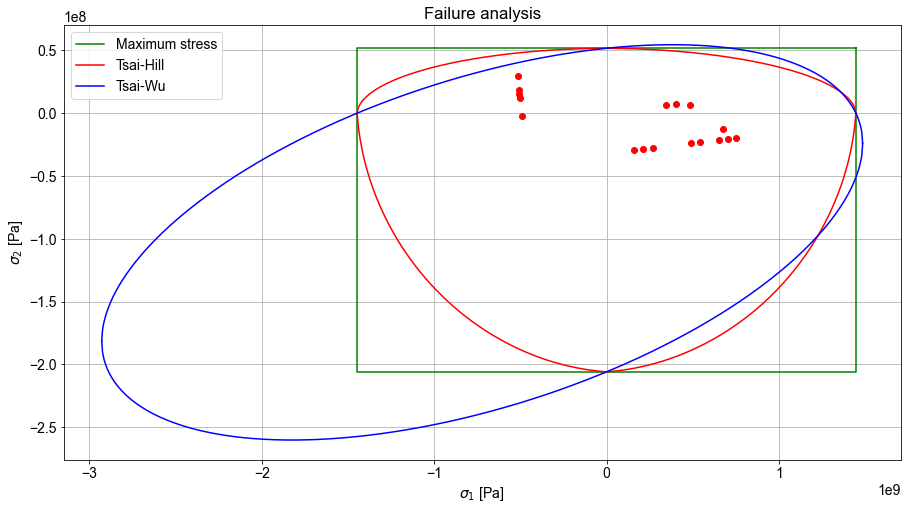

In [178]:
# Graph configurations
matplotlib.rc('font', family = 'Arial')
matplotlib.rc('font', size = 14)

# Graph building function
def grafalha(XT,XC,YT,YC,S12,sigma_1_c,sigma_1_t,tau12,sigma_2):
    for k in range(249):
        sigma_2[k]     = (YT*np.sqrt(-4*XT**4*tau12**2+(S12**2*YT**2-4*S12**2*XT**2)*sigma_1_t[k]**2+4*S12**2*XT**4)-S12*YT**2*sigma_1_t[k])/(2*S12*XT**2)
        sigma_2[k+250] = (YT*np.sqrt(-4*XC**4*tau12**2+(S12**2*YT**2-4*S12**2*XC**2)*sigma_1_c[k]**2+4*S12**2*XC**4)+S12*YT**2*sigma_1_c[k])/(2*S12*XC**2)
        sigma_2[k+500] = (YC*np.sqrt(-4*XC**4*tau12**2+(S12**2*YC**2-4*S12**2*XC**2)*sigma_1_c[k]**2+4*S12**2*XC**4)-S12*YC**2*sigma_1_c[k])/(2*S12*XC**2)
        sigma_2[k+750] = (YC*np.sqrt(-4*XT**4*tau12**2+(S12**2*YC**2-4*S12**2*XT**2)*sigma_1_t[k]**2+4*S12**2*XT**4)+S12*YC**2*sigma_1_t[k])/(2*S12*XT**2)
    
    x_inter1 = -(2*(YC*YT*(S12**2*XC*XT*YC**2 + S12**2*XC*XT*YT**2 + S12**2*XC**2*YC*YT + S12**2*XT**2*YC*YT + S12**2*XC*XT*YC*YT + 3*XC*XT*YC*YT*tau12**2 - S12**2*XC*XT**2*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC*XT**2*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC**2*XT*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC**2*XT*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2)))**(1/2) - 2*S12*XC*YC*YT - 2*S12*XT*YC*YT + S12*XC*XT*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) + S12*XC*XT*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2))/(3*S12*YC*YT)
    x_inter2 = (2*(YC*YT*(S12**2*XC*XT*YC**2 + S12**2*XC*XT*YT**2 + S12**2*XC**2*YC*YT + S12**2*XT**2*YC*YT + S12**2*XC*XT*YC*YT + 3*XC*XT*YC*YT*tau12**2 - S12**2*XC*XT**2*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC*XT**2*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC**2*XT*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12**2*XC**2*XT*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2)))**(1/2) + 2*S12*XC*YC*YT + 2*S12*XT*YC*YT - S12*XC*XT*YC*YT**2*(1/(XC*XT*YC*YT))**(1/2) - S12*XC*XT*YC**2*YT*(1/(XC*XT*YC*YT))**(1/2))/(3*S12*YC*YT)
    
    sig1 = np.linspace(x_inter1,x_inter2, 1000)
    sig2 = np.linspace(0, 0, 1000)
    sig3 = np.linspace(0, 0, 1000)

    for k in range(1000):
        sig2[k] = (np.sqrt(4*XC**2*XT**2*YC*YT*tau12**2-3*S12**2*XC*XT*YC*YT*sig1[k]**2+(((4*S12**2*XC*XT**2+4*S12**2*XC**2*XT)*YC-2*S12**2*XC**2*XT**2*YC**2*np.sqrt(1/(XC*XT*YC*YT)))*YT-2*S12**2*XC**2*XT**2*YC*np.sqrt(1/(XC*XT*YC*YT))*YT**2)*sig1[k]+S12**2*XC**2*XT**2*YT**2-2*S12**2*XC**2*XT**2*YC*YT+S12**2*XC**2*XT**2*YC**2)-S12*XC*XT*YC*np.sqrt(1/(XC*XT*YC*YT))*YT*sig1[k]+S12*XC*XT*YT+S12*XC*XT*YC)/(2*S12*XC*XT)
        sig3[k] = -(np.sqrt(4*XC**2*XT**2*YC*YT*tau12**2-3*S12**2*XC*XT*YC*YT*sig1[k]**2+(((4*S12**2*XC*XT**2+4*S12**2*XC**2*XT)*YC-2*S12**2*XC**2*XT**2*YC**2*np.sqrt(1/(XC*XT*YC*YT)))*YT-2*S12**2*XC**2*XT**2*YC*np.sqrt(1/(XC*XT*YC*YT))*YT**2)*sig1[k]+S12**2*XC**2*XT**2*YT**2-2*S12**2*XC**2*XT**2*YC*YT+S12**2*XC**2*XT**2*YC**2)+S12*XC*XT*YC*np.sqrt(1/(XC*XT*YC*YT))*YT*sig1[k]-S12*XC*XT*YT-S12*XC*XT*YC)/(2*S12*XC*XT)
    
    # Size of the figure
    plt.figure(figsize=(15,8))

    # Maximum stress
    plt.plot([XT,XC,XC,XT,XT],[YT,YT,YC,YC,YT],'g',label = 'Maximum stress')

    # Tsai-Hill
    plt.plot(sigma_1_t,sigma_2[0:249],'r',label = 'Tsai-Hill') #Tsai-Hill 1st quadrant
    plt.plot(sigma_1_c,sigma_2[250:499],'r') #Tsai-Hill 2nd quadrant
    plt.plot(sigma_1_c,sigma_2[500:749],'r') #Tsai-Hill 3rd quadrant
    plt.plot(sigma_1_t,sigma_2[750:999],'r') #Tsai-Hill 4th quadrant

    # Tsai-Wu
    plt.plot(sig1,sig2,'b',label = 'Tsai-Wu') #Tsai-Wu positive
    plt.plot(sig1,sig3,'b') #Tsai-Wu negative

    for i in range(n):
        plt.plot(sigma_local[i][0,0],sigma_local[i][1,0],'ro')
   
    plt.title('Failure analysis')
    plt.xlabel("${\sigma_1}$ [Pa]")
    plt.ylabel("${\sigma_2}$ [Pa]")
    plt.grid()
    plt.legend()

# Generic stress
sigma_1_c = np.linspace(XC, 0, 249)
sigma_1_t = np.linspace(0, XT, 249)
tau12 = 0
sigma_2 = np.linspace(0, 0, 1000)

fig0 = grafalha(XT,XC,YT,YC,S12,sigma_1_c,sigma_1_t,tau12,sigma_2)


# Stress and strain in the middle, top and bottom of each lamina

In [179]:
# Changing the precision for better results
np.set_printoptions(precision=6)

# Empty vectors
z = np.array(np.zeros([3,n]))
epsilon_graph = np.array(np.zeros([3,n*3]))
sigma_graph = np.array(np.zeros([3,n*3]))

for i in range(n):
    z[0,i] = (((n/2 - i)/n)*-h)
    z[1,i] = 0.5*(((((n/2)-(i+1))/n)*-h) + (((n/2 - i)/n)*-h))
    z[2,i] = ((((n/2)-(i+1))/n)*-h)

    # Strain (global coordinates)
    mat_0 = (np.array(epsilon_0_global) + z[0,i]*np.array(K_global))
    mat_1 = (np.array(epsilon_0_global) + z[1,i]*np.array(K_global))
    mat_2 = (np.array(epsilon_0_global) + z[2,i]*np.array(K_global))
    
    # positioning new data (must be improved)
    epsilon_graph[0,i] = mat_0[0,0]
    epsilon_graph[1,i] = mat_0[1,0]
    epsilon_graph[2,i] = mat_0[2,0]
    epsilon_graph[0,i+n] = mat_1[0,0]
    epsilon_graph[1,i+n] = mat_1[1,0]
    epsilon_graph[2,i+n] = mat_1[2,0]
    epsilon_graph[0,i+2*n] = mat_2[0,0]
    epsilon_graph[1,i+2*n] = mat_2[1,0]
    epsilon_graph[2,i+2*n] = mat_2[2,0]
    
    # Stress (global coordinates)
    tens_0 = (Q_dash[i]@(epsilon_0_global + (z[0,i]*K_global)))
    tens_1 = (Q_dash[i]@(epsilon_0_global + (z[1,i]*K_global)))
    tens_2 = (Q_dash[i]@(epsilon_0_global + (z[2,i]*K_global)))

    # positioning new data (must also be improved)
    sigma_graph[0,i] = tens_0[0,0]*10**-6
    sigma_graph[1,i] = tens_0[1,0]*10**-6
    sigma_graph[2,i] = tens_0[2,0]*10**-6
    sigma_graph[0,i+n] = tens_1[0,0]*10**-6
    sigma_graph[1,i+n] = tens_1[1,0]*10**-6
    sigma_graph[2,i+n] = tens_1[2,0]*10**-6
    sigma_graph[0,i+2*n] = tens_2[0,0]*10**-6
    sigma_graph[1,i+2*n] = tens_2[1,0]*10**-6
    sigma_graph[2,i+2*n] = tens_2[2,0]*10**-6


# Strain distribution along the laminas graph

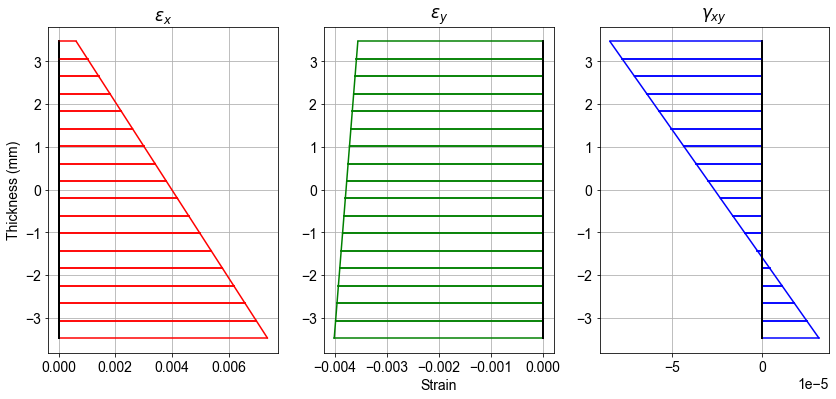

In [180]:
fig, (ax,ax2,ax3) = plt.subplots(1,3, figsize=(14,6))

# In milimeters
z = z*1000

ax.plot([epsilon_graph[0,0:n],epsilon_graph[0,n:2*n],epsilon_graph[0,2*n:3*n]],[z[0,:],z[1,:],z[2,:]],'r')
ax2.plot([epsilon_graph[1,0:n],epsilon_graph[1,n:2*n],epsilon_graph[1,2*n:3*n]],[z[0,:],z[1,:],z[2,:]],'g')
ax3.plot([epsilon_graph[2,0:n],epsilon_graph[2,n:2*n],epsilon_graph[2,2*n:3*n]],[z[0,:],z[1,:],z[2,:]],'b')

# Lines to separate the laminas
for i in range(n):
    ax.plot([0,epsilon_graph[0,i]],[z[0,i],z[0,i]],'r')
    ax.plot([0,epsilon_graph[0,i+2*n]],[z[2,i],z[2,i]],'r')
    ax.plot([0,0],[z[0,0],z[2,n-1]],'k')
    
    ax2.plot([0,epsilon_graph[1,i]],[z[0,i],z[0,i]],'g')
    ax2.plot([0,epsilon_graph[1,i+2*n]],[z[2,i],z[2,i]],'g')
    ax2.plot([0,0],[z[0,0],z[2,n-1]],'k')

    ax3.plot([0,epsilon_graph[2,i]],[z[0,i],z[0,i]],'b')
    ax3.plot([0,epsilon_graph[2,i+2*n]],[z[2,i],z[2,i]],'b')
    ax3.plot([0,0],[z[0,0],z[2,n-1]],'k')

# General characteristics
ax.set(ylabel='Thickness (mm)', title='$\epsilon_x$')
ax2.set(xlabel='Strain', title='$\epsilon_y$')
ax3.set(title='$\gamma_{xy}$')

ax.grid()
ax2.grid()
ax3.grid()


# Stress distribution along the laminas graph

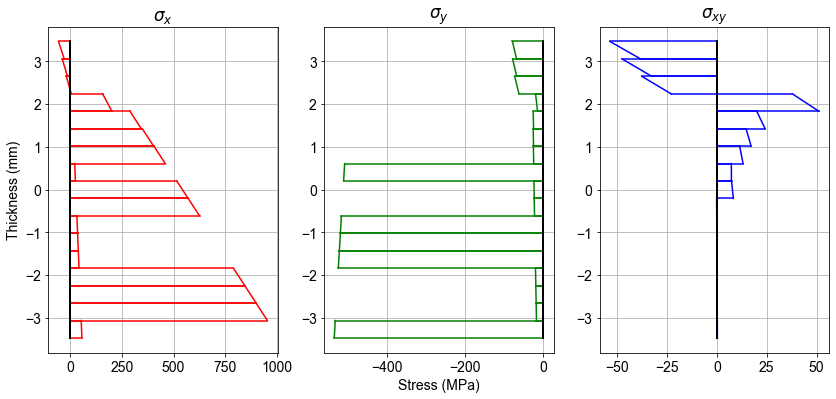

In [181]:
fig, (ax,ax2,ax3) = plt.subplots(1,3, figsize=(14,6))

ax.plot([sigma_graph[0,0:n],sigma_graph[0,n:2*n],sigma_graph[0,2*n:3*n]],[z[0,:],z[1,:],z[2,:]],'r')
ax2.plot([sigma_graph[1,0:n],sigma_graph[1,n:2*n],sigma_graph[1,2*n:3*n]],[z[0,:],z[1,:],z[2,:]],'g')
ax3.plot([sigma_graph[2,0:n],sigma_graph[2,n:2*n],sigma_graph[2,2*n:3*n]],[z[0,:],z[1,:],z[2,:]],'b')

# Lines to separate the laminas
for i in range(n):
    ax.plot([0,sigma_graph[0,i]],[z[0,i],z[0,i]],'r')
    ax.plot([0,sigma_graph[0,i+2*n]],[z[2,i],z[2,i]],'r')
    ax.plot([0,0],[z[0,0],z[2,n-1]],'k')

    ax2.plot([0,sigma_graph[1,i]],[z[0,i],z[0,i]],'g')
    ax2.plot([0,sigma_graph[1,i+2*n]],[z[2,i],z[2,i]],'g')
    ax2.plot([0,0],[z[0,0],z[2,n-1]],'k')

    ax3.plot([0,sigma_graph[2,i]],[z[0,i],z[0,i]],'b')
    ax3.plot([0,sigma_graph[2,i+2*n]],[z[2,i],z[2,i]],'b')
    ax3.plot([0,0],[z[0,0],z[2,n-1]],'k')
        
ax.set(ylabel='Thickness (mm)', title='$\sigma_x$')
ax2.set(xlabel='Stress (MPa)', title='$\sigma_y$')
ax3.set(title='$\sigma_{xy}$')

ax.grid()
ax2.grid()
ax3.grid()
